In [1]:
from Functions import *
from savgol import savitzky_golay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import gzip
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pickle as pkl
import george
from george import kernels
from select_lc import *
from numpy import math
import traceback
import sys
from tqdm import tqdm

cmd_folder = os.path.realpath(os.getenv("SESNCFAlib"))

if cmd_folder not in sys.path:
     sys.path.insert(0, cmd_folder)
import templutils as templutils

%matplotlib inline

In [4]:
lc_direc = os.getenv("SESNPATH") + './../Somayeh_contributions/main/ELASTICC_lc/'

SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']

bands = ['R','V','r','g','U','u','J','B','H','I','i','K','m2','w1','w2']
colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'Ibn':'purple'}

lsst_bands = {'0':'u',
              '1':'g',
              '2': 'r',
              '3': 'i',
              '4': 'z',
              '5': 'y'}

clrs =  {'0':'b',
              '1':'g',
              '2': 'r',
              '3': 'purple',
              '4': 'cyan',
              '5': 'k'}

su = templutils.setupvars()
coffset = su.coffset

In [3]:
ref = coffset['r']
for b in coffset.keys():
    coffset[b] = coffset[b] - ref

Paths to where the Elasticc light curves are stored:

Paths to Ib's: 

    'ELASTICC_TRAIN_SNIb+HostXT_V19/'
    
    'ELASTICC_TRAIN_SNIb-Templates/'
    
Paths to Ic's:

    'ELASTICC_TRAIN_SNIc+HostXT_V19/'
    
    'ELASTICC_TRAIN_SNIc-Templates/'
    
Paths to Ic-bl's:

    'ELASTICC_TRAIN_SNIcBL-+HostXT_V19/'
    

In [5]:
# To select a sample of the Elasticc light curves with low redshift,
#high S/N ratio and at least 1 data point 5 days around the peak:
directory = lc_direc + 'ELASTICC_TRAIN_SNIb+HostXT_V19/'

In [6]:
# To read in saved selected lc:

pklf = directory + 'high_SNIb+HostXT_peak_covered_low_redshift.pkl'
selected_lc = pkl.load(open(pklf, "rb"))

In [7]:
len(selected_lc.keys())

232

In [8]:
# Reading in GP templates in any bands requested

tmpl = {}

bands = ['up', 'g', 'rp', 'ip']

for bb in bands:

    tmpl[bb[0]] = {}

    for SNTYPE in SNTYPES:
        
        tmpl[bb[0]][SNTYPE] = {}


        try:
            path = os.getenv("SESNPATH") + "maketemplates/outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl"%(SNTYPE,bb)
            tmpl_ = pkl.load(open(path, "rb"))
        except:
            continue
        
#         print(tmpl_['rollingMedian'])

        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue

        tmpl[bb[0]][SNTYPE] = tmpl_





In [10]:
# Test fitting algorithms to a single light curve

keys = np.asarray(selected_lc.keys())
ID = '4'
b = 'r'
# selected_lc = all_selected_lc[1]

t = selected_lc[ID][b]['t']
f = selected_lc[ID][b]['f']
ferr = selected_lc[ID][b]['ferr']

t = t[f>0]
ferr = ferr[f>0]
f = f[f>0]

if len(f) == 0:
    print(ID)

m = 27.5 - 2.5*np.log10(f) #-2.5*np.log10(f/(10**(-0.4*27.5)))
median = np.nanmedian(m)
#         m = m- median
merr = 2.5 / np.log(10) * ferr / f

if b == 'r':
    x_peak_ref = t[np.argmin(m)]

x_peak = x_peak_ref + coffset[b]
y_peak = m[np.argmin(m)]

# if np.sum(t - x_peak < 0) <3:
#     print('Not enough data before the peak')

low_lim = -25
up_lim = 100

ind = (t < up_lim + x_peak) & (t > low_lim + x_peak)
y = m[ind]
yerr = merr[ind]
x = t[ind]
xx = x - x_peak_ref
f = f[ind]
ferr = ferr[ind]

t_new, func, p0 = lc_fit(np.row_stack((t[ind], f, ferr)), x_peak = x_peak)

m_func = 27.5 - 2.5*np.log10(func) #-2.5*np.log10(f/(10**(-0.4*27.5)))
# median = np.nanmedian(m_func)
y = y - np.nanmin(m_func)
m_func = m_func - np.nanmin(m_func)


/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/elastic_data/Functions.py:70: RuntimeWarning: overflow encountered in power
  exp_rise = np.e**(np.asarray(shift * (t - t0))) + 1
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/elastic_data/Functions.py:87: RuntimeWarning: overflow encountered in square
  return (np.sum((f-model)**2*inv_sigma2))
/Users/somayeh/opt/anaconda3/envs/pyt38/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/elastic_data/Functions.py:81: RuntimeWarning: overflow encountered in multiply
  return exp_fit(t, t0, shift) * (gaussian + linear)


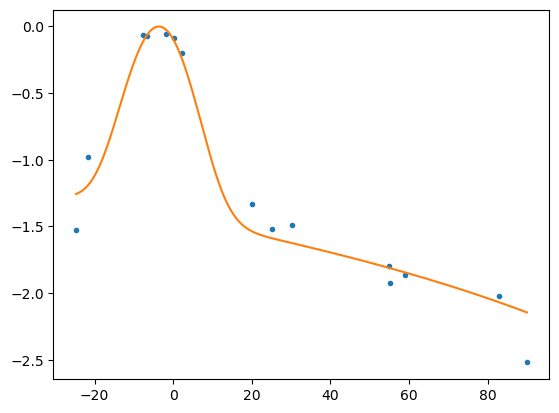

In [11]:
plt.plot(x-x_peak, -y, '.')
plt.plot(t_new, -m_func)
# plt.axvline(x_peak - p0[1])

# plt.xlim(-50,0)

In [63]:
# pkl.dump(selected_lc, open('high_SN_Ic_Templates_peak_covered_low_redshift.pkl', "wb"))


/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_60919/4165716083.py:59: RuntimeWarning: invalid value encountered in log10
  m_func = 27.5 - 2.5*np.log10(func) #-2.5*np.log10(f/(10**(-0.4*27.5)))
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_60919/4165716083.py:153: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=50)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_60919/4165716083.py:154: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=50)
/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_60919/4165716083.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=50)
/var/folder

Text(0.02, 0.5, 'Relative Magnitude')

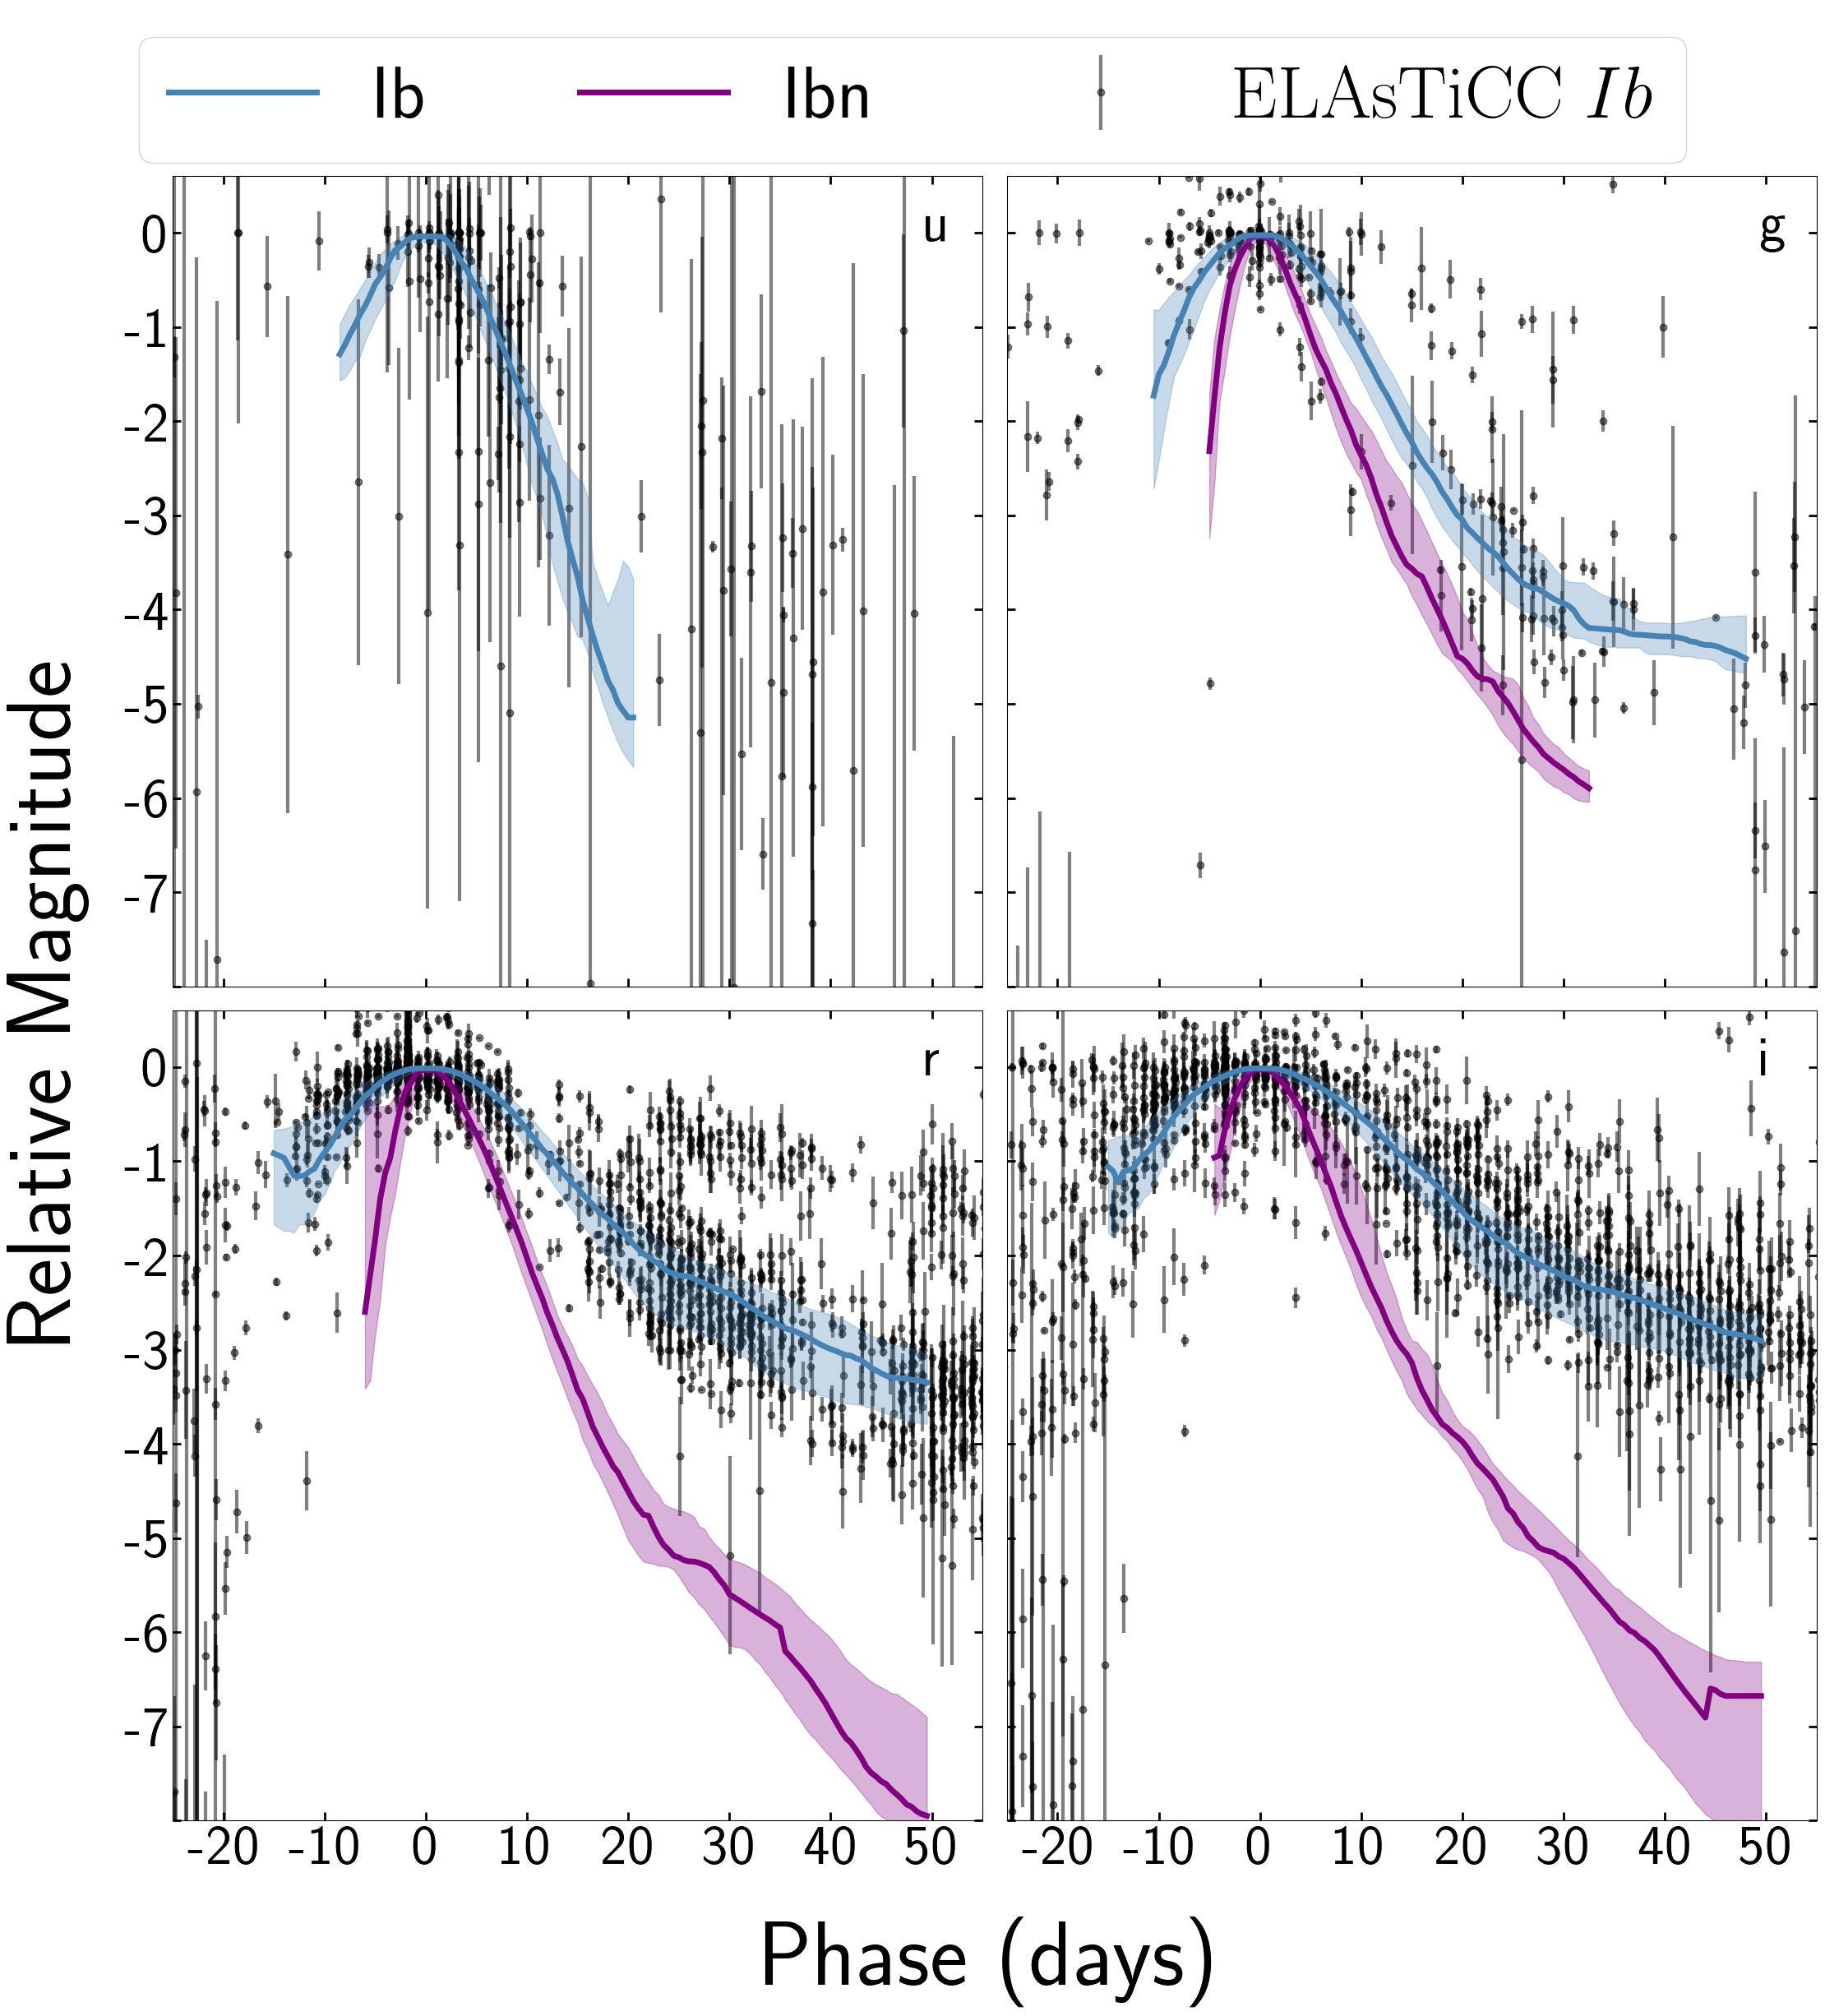

In [24]:
# ugrizy = 012345
bb = ['r','u','g','i']
b_ = [2,0,1,3]

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
elasticc_sntype = 'Ib'

SNTYPES_ = {'Ib':['Ib', 'Ibn'],
            'Ic':['Ic', 'Ic-bl'],
            'Ic-bl':['Ic', 'Ic-bl']}
# u, g, r, i

max_u = [[],[]]
max_g = [[],[]]
max_r = [[],[]]
max_i = [[],[]]


plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))
        
    
for i,ID in enumerate(list(selected_lc.keys())):
#     print(ID)
    
    for j, b in enumerate(bb): 
#         print(b)


        t = selected_lc[ID][b]['t']
        f = selected_lc[ID][b]['f']
        ferr = selected_lc[ID][b]['ferr']
        
        t = t[f>0]
        ferr = ferr[f>0]
        f = f[f>0]
        
        y = 27.5 - 2.5*np.log10(f)
        yerr = 2.5 / np.log(10) * ferr / f
        x = t
        
        x_peak_ref = selected_lc[ID]['r']['t'][np.argmax(selected_lc[ID]['r']['f'])]
        x_peak = x_peak_ref + coffset[b]

        t_new = selected_lc[ID][b]['t_new']
        func = selected_lc[ID][b]['f_func']
        
        if np.sum(~np.isnan(func)) == 0:
            new_x_peak = x_peak
            new_y_peak = 0
#             print(ID)
            continue
        else:

            m_func = 27.5 - 2.5*np.log10(func) #-2.5*np.log10(f/(10**(-0.4*27.5)))
            if np.sum(np.isinf(m_func))>0:
                print(b, ID)
                continue
            xx = np.linspace(x.min(), x.max(), 1000)
            new_x_peak = xx[m_func == np.nanmin(m_func)]
            new_t_peak = t_new[m_func == np.nanmin(m_func)]
            new_y_peak = np.nanmin(m_func)
            if np.abs(new_y_peak - np.min(y))>0.5:
                new_y_peak = y[np.argmin(np.abs(x-new_t_peak))]





        if i == 1:

            np.concatenate(ax)[b_[j]].errorbar(x - x_peak,\
                new_y_peak - y , yerr=yerr, fmt='o',\
                linewidth = 3, color = 'k',
                label = r'$\mathrm{ELAsTiCC }\; Ib$', alpha = 0.5)
#             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'k', alpha = 0.1, label = 'VL fit')


        else:
            np.concatenate(ax)[b_[j]].errorbar(x - x_peak,\
                new_y_peak -y , yerr=yerr, fmt='o',\
                linewidth = 3, color = 'k', alpha = 0.5)
#             np.concatenate(ax)[b_[j]].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'k', alpha = 0.1)


for j, b in enumerate(bb):
    
    for tp in SNTYPES_[elasticc_sntype]:
        
        if tp != elasticc_sntype:
            alpha = 1
            zorder = 15
        else:
            alpha = 1
            zorder = 19
            
        if b == 'r':
            try:

                np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],
                        tmpl[b][tp]['rollingMedian'],
                        '-',color = colorTypes[tp], alpha = alpha,
                        linewidth=5, zorder = zorder, label = tp)
                np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                        tmpl[b][tp]['rollingPc25'],\
                        tmpl[b][tp]['rollingPc75'],\
                        alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)
            except:
                pass 
        else:
            
            
            try:
                if b == 'g' and tp == 'Ic':

                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingMedian'][tmpl[b][tp]['t']<35],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc25'][tmpl[b][tp]['t']<35],\
                            tmpl[b][tp]['rollingPc75'][tmpl[b][tp]['t']<35],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)
                else:
                    np.concatenate(ax)[b_[j]].plot(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingMedian'],'-', alpha = alpha,\
                            color = colorTypes[tp],linewidth=5, zorder = zorder)
                    np.concatenate(ax)[b_[j]].fill_between(tmpl[b][tp]['t'],\
                            tmpl[b][tp]['rollingPc25'],\
                            tmpl[b][tp]['rollingPc75'],\
                            alpha = 0.3*alpha, color = colorTypes[tp], zorder = zorder)
            except:
                    pass 

    #     plt.title('Plasticc I light curves compared with GP templates in ' + str(bb) + ' band', size=30)
        
#         plt.legend(loc = 'lower left', ncol=3, prop={'size':30})
        np.concatenate(ax)[b_[j]].tick_params(axis="both", direction="in", which="major",\
                                              right=True, top=True, size=7, labelsize=25, width = 2)
    
    np.concatenate(ax)[b_[j]].text(0.93, 0.92, b, transform=np.concatenate(ax)[b_[j]].transAxes,\
                               weight='bold', size = 50, color = 'k')
    
handles, labels = np.concatenate(ax)[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':65})
np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=50)
np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=50)

np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=50)
np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=50)


np.concatenate(ax)[0].set_xlim(-25,55)
np.concatenate(ax)[0].set_ylim(-4,0.3)
plt.subplots_adjust(hspace=.03, wspace=0.03, top = 0.9, left = 0.1, bottom = 0.1)

fig.text(0.5, 0.02, 'Phase (days)', ha='center', size = 80)
fig.text(0.02, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 80)


# plt.savefig('elasticc_SNIb+HostX_gp_tmpl_ugri_high_SN_peak_covered_low_redshift_VL_poster.pdf', bbox_inches='tight')

<ErrorbarContainer object of 3 artists>

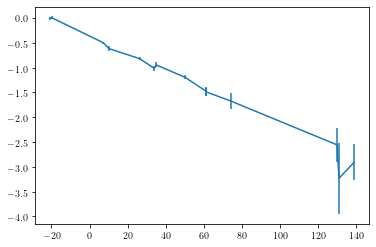

In [46]:
plt.errorbar(x - x_peak,\
                new_y_peak - y , yerr=yerr)